In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# 多行输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

## 图像重建

### 图像重建含义
- 低分辨率 --> 高分辨率
- 黑白 --> 彩色
- 恢复已是的像素
- 图像风格转移

In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

- 仍然使用Pets 训练集，但是故意弄糊

In [2]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'crappy'

In [4]:
from crappify import *

- 生成低分辨率图片

In [5]:
# il = ImageList.from_folder(path_hr)
# parallel(crappifier(path_lr, path_hr), il.items)

In [6]:
path.ls()

[PosixPath('/home/lyc/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/home/lyc/.fastai/data/oxford-iiit-pet/crappy'),
 PosixPath('/home/lyc/.fastai/data/oxford-iiit-pet/annotations')]

- 逐步调整大小，往往能获得更好的效果

In [3]:
bs,size=32, 128
# bs,size = 24,160
#bs,size = 8,256
arch = models.resnet34

### 生成器

In [4]:
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

- `tfm_y=True` ， `do_y=True` 标签也要做相应变化

In [5]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
            .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
            .databunch(bs=bs)
            .normalize(imagenet_stats, do_y=True))
    data.c = 3
    return data

In [6]:
data_gen = get_data(bs,size)

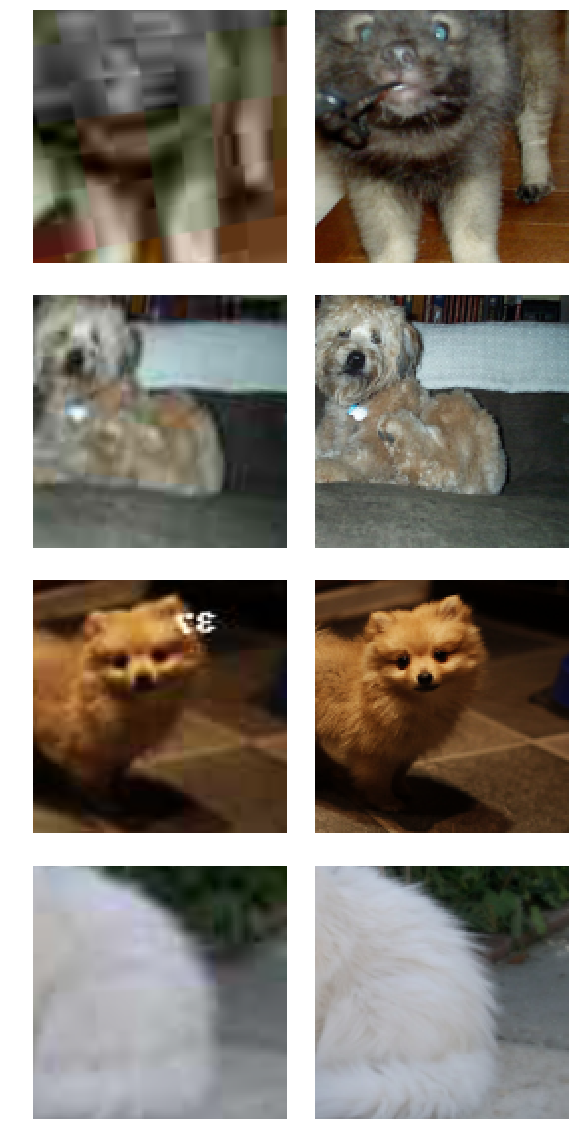

In [11]:
data_gen.show_batch(4)

- 学习器构建

In [7]:
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)

In [35]:
doc(MSELossFlat)
# MSE是计算两个向量之间的损失，这里是图像，所以要先展开

MSELossFlat [source] [test] MSELossFlat ( * args , axis : int = -1 , floatify : bool = True , ** kwargs ) 
 
 × No tests found for MSELossFlat . To contribute a test please refer to this guide and this discussion . Same as nn.MSELoss , but flattens input and target. 
 Show in docs

In [8]:
wd = 1e-3
y_range = [-3., 3.]
loss_gen = MSELossFlat()

In [15]:
learn_gen = create_gen_learner()

In [17]:
learn_gen.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.02E-03


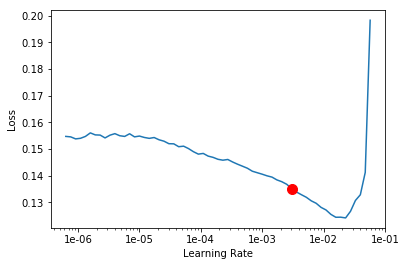

In [18]:
learn_gen.recorder.plot(suggestion=True)

In [20]:
lr = 3e-3

In [21]:
learn_gen.fit_one_cycle(5, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,time
0,0.065688,0.057673,01:47
1,0.054691,0.051543,01:06
2,0.052530,0.048191,01:06
3,0.050580,0.047331,01:05
4,0.048293,0.043944,01:05


In [22]:
learn_gen.save('s1')

In [27]:
learn_gen.load('s1');

In [28]:
learn_gen.unfreeze()

In [29]:
learn_gen.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.32E-04


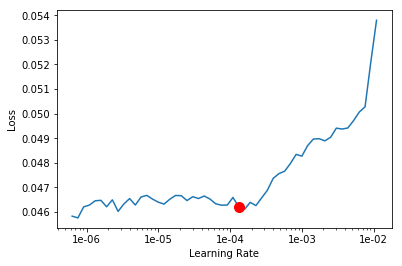

In [30]:
learn_gen.recorder.plot(suggestion=True)

In [31]:
lr1 = 1e-4

In [32]:
learn_gen.fit_one_cycle(3, slice(lr1/2.6**(len(learn_gen.layer_groups)),lr1))

epoch,train_loss,valid_loss,time
0,0.046055,0.043692,01:09
1,0.046670,0.043439,01:11
2,0.046430,0.043431,01:10


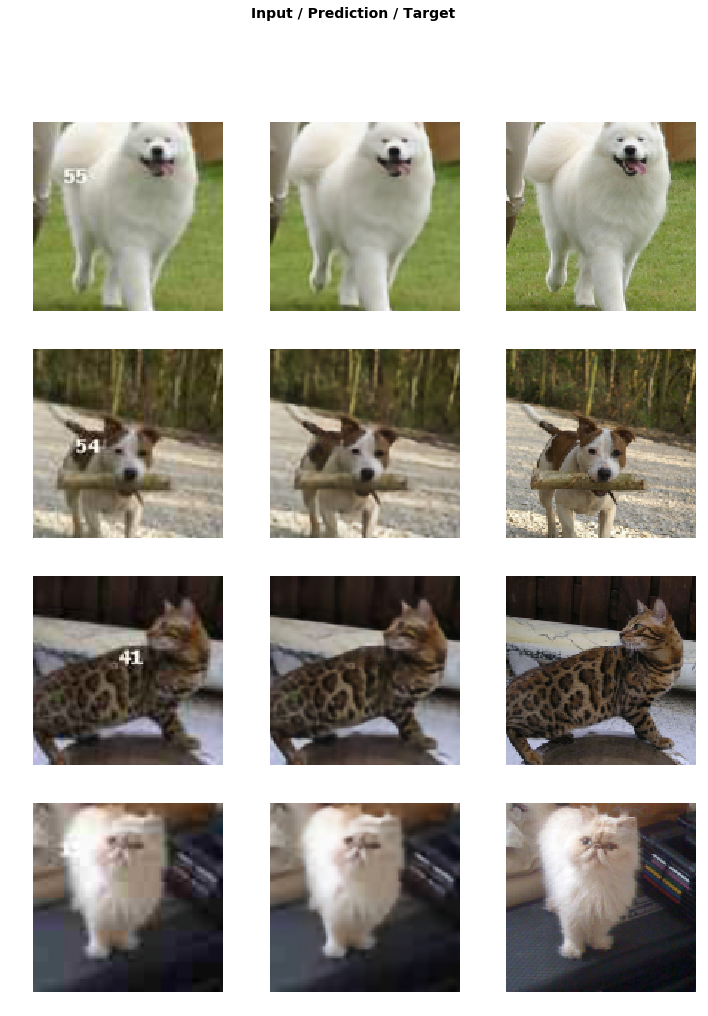

In [33]:
learn_gen.show_results(rows=4)

In [34]:
learn_gen.save('s2')

- 用二分类判断图片是生成的高分辨率图片还是本身就是高分辨率
- 生成器和判别器都使用预训练模型

### 保存生成器生成的图片

In [36]:
learn_gen.load('s2');

In [11]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [38]:
path_gen.mkdir(exist_ok=True)

In [39]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

In [40]:
save_preds(data_gen.fix_dl)

- 清内存 避免重启

In [47]:
learn_gen=None
gc.collect()

AttributeError: 'NoneType' object has no attribute 'destory'

### 判别器
- 使用判别器生成的图片作为输入

In [9]:
def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

In [12]:
data_crit = get_crit_data([name_gen, 'images'], bs=bs, size=size)

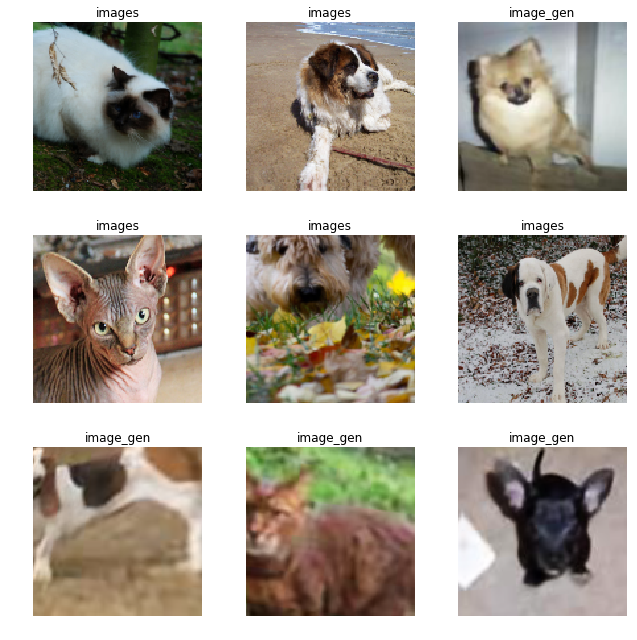

In [50]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [13]:
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

- 判别器损失函数

In [53]:
doc(AdaptiveLoss)

class AdaptiveLoss [source] [test] AdaptiveLoss ( crit ) :: Module 
 
 × No tests found for AdaptiveLoss . To contribute a test please refer to this guide and this discussion . Expand the target to match the output size before applying crit . 
 Show in docs

In [54]:
doc(accuracy_thresh_expand)

accuracy_thresh_expand [source] [test] accuracy_thresh_expand ( y_pred : Tensor , y_true : Tensor , thresh : float = 0.5 , sigmoid : bool = True ) → Rank0Tensor 
 
 × No tests found for accuracy_thresh_expand . To contribute a test please refer to this guide and this discussion . Compute accuracy after expanding y_true to the size of y_pred . 
 Show in docs

In [64]:
doc(gan_critic)

gan_critic [source] [test] gan_critic ( n_channels : int = 3 , nf : int = 128 , n_blocks : int = 3 , p : int = 0.15 ) 
 
 × No tests found for gan_critic . To contribute a test please refer to this guide and this discussion . Critic to train a GAN . 
 Show in docs

In [14]:
wd=1e-3
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [55]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E+00


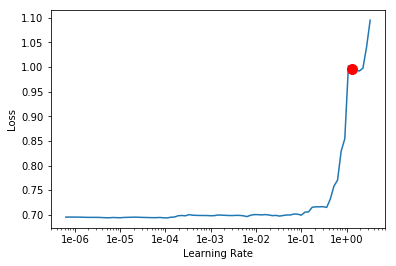

In [57]:
learn_critic.lr_find()
learn_critic.recorder.plot(suggestion=True)

In [58]:
lr2 = 1e-3

In [59]:
learn_critic.fit_one_cycle(6, lr2)

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.691829,0.720696,0.512108,02:30
1,0.470332,0.527426,0.774017,02:29
2,0.187466,0.275755,0.888148,02:30
3,0.095659,0.106986,0.961140,02:30
4,0.058637,0.109766,0.958405,02:32
5,0.052754,0.060835,0.982365,02:30


In [60]:
learn_critic.save('critic-1')

In [62]:
learn_critic.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace)
  )
  (1): Dropout2d(p=0.075)
  (2): SequentialEx(
    (layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2, inplace)
      )
      (1): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2, inplace)
      )
      (2): MergeLayer()
    )
  )
  (3): Dropout2d(p=0.15)
  (4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): SelfAttention(
      (query): Conv1d(512, 64, kernel_size=(1,), stride=(1,), bias=False)
      (key): Conv1d(512, 64, kernel_size=(1,), stride=(1,), bias=False)
      (value): Conv1d(512, 512, kernel_size=(1,), stride=(1,), bias=

- spectral norm 在判别器中非常重要
- A GAN critic uses a slightly different way of averaging the different parts of the image when it does the loss, so anytime you're doing a GAN at the moment, you have to wrap your loss function with AdaptiveLoss.

### GAN
- 使用GAN将判别器生成器组合

In [66]:
learn_crit=None
learn_gen=None
gc.collect()

9354

In [15]:
data_crit = get_crit_data(['crappy', 'images'], bs=bs, size=size)

In [17]:
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-1')

In [18]:
learn_gen = create_gen_learner().load('s2')

- 定义 switcher 用于判断判别器与生成器之间的切换模式

In [19]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)

- GAN 学习器定义

In [20]:
wd=1e-3

- GAN 中 动量无效 `partial(optim.Adam, betas=(0.,0.99))`

In [21]:
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)

In [22]:
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [23]:
learn.fit_one_cycle(30, slice(1e-4))

In [36]:
learn.save('gan1')

- 增大图片 继续训练

In [24]:
learn.data=get_data(8, 192)

In [25]:
learn.fit_one_cycle(30, slice(1e-4/2))

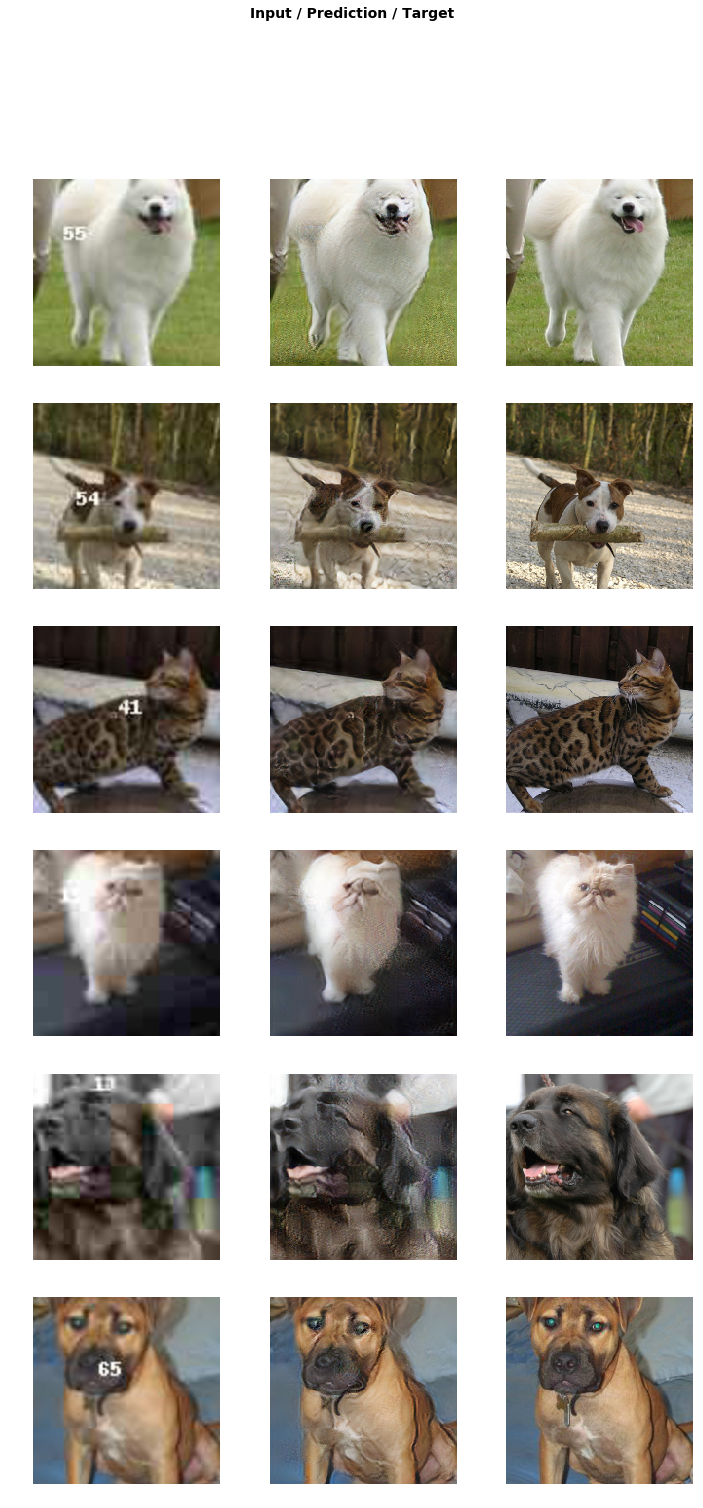

In [26]:
learn.show_results(rows=6)

In [27]:
learn.save('gan2')